# Plot surface elevations and bed topography along the centerline

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import xarray as xr
from matplotlib.cm import ScalarMappable

## Define paths in directory

In [2]:
# Path to Hubbard data for convenience
base_path = '/Users/raineyaberle/Research/Hubbard/'

# Where figure will be saved
figures_out_path = os.path.join(base_path, 'figures') 

# Bed topography
bed_fn = os.path.join(base_path, 'bed_topo', 'hubbard_bedrock_icebridge.tif')

# Centerline
cl_fn = os.path.join(base_path, 'velocity', 'center_50m.gpkg')

# Surface elevations
h_cl_fn = os.path.join(base_path, 'DEMs', 'centerline_surface_elevation_timeseries_smooth.csv')

## Load data

In [3]:
# Bed
bed = xr.open_dataset(bed_fn)

# Centerline
cl = gpd.read_file(cl_fn)
# calculate distance vector
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist
cl_dist = create_distance_vector(cl.geometry[0])

# Surface elevations along centerline
h_cl_df = pd.read_csv(h_cl_fn)
h_cl_df['Date'] = pd.to_datetime(h_cl_df['Date'])

# Plot bed and centerline map
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.band_data.data[0], cmap='Greys_r', clim=(-0.5e3, 1.5e3),
                   extent=(np.min(bed.x.data), np.max(bed.x.data),
                           np.min(bed.y.data), np.max(bed.y.data)))
cl.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, shrink=0.8, label='Bed topography [m]')

plt.show()

RasterioIOError: /Users/raineyaberle/Research/Hubbard/bed_topo/hubbard_bedrock_icebridge.tif: No such file or directory

## Plot

NameError: name 'h_cl_df' is not defined

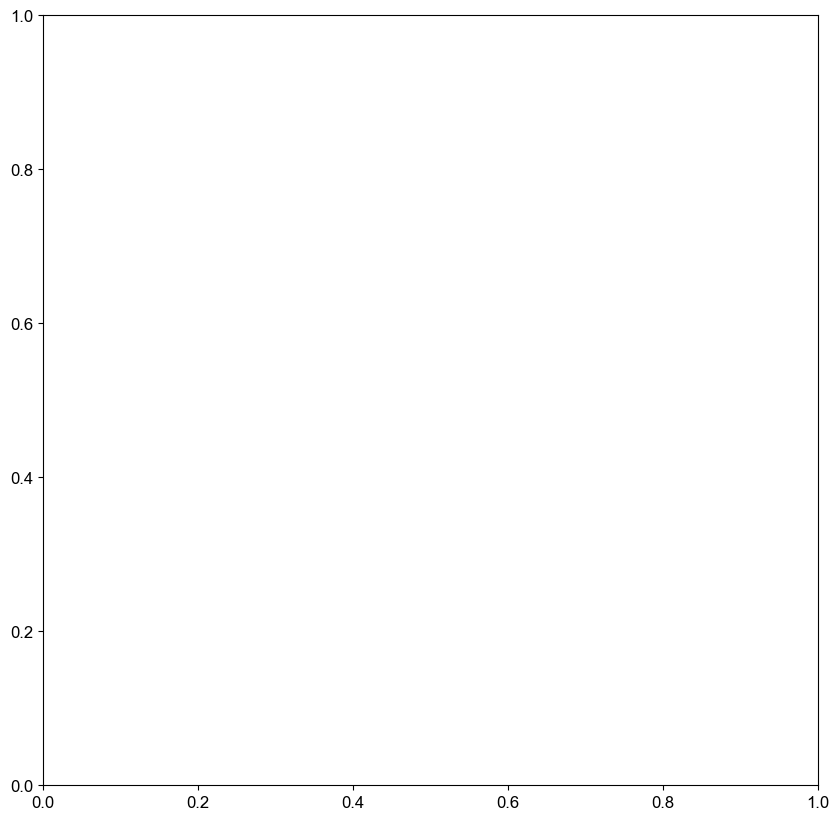

In [4]:
# Set up figure
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 1, figsize=(10,10))
lw=1.5

# Define colormap for surface profiles
cmap = plt.cm.twilight

# Plot surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.0' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax.plot(cl_dist, h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)

# Plot bed
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]
ax.plot(cl_dist, bed_cl, '-k', linewidth=lw, label='Bed topography')

# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, location='top')
cbar.ax.set_xticks(np.linspace(0,1,num=12))
cbar.ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust axes
ax.legend(loc='lower left')
ax.grid()
ax.set_xlabel('Distance along centerline [m]')
ax.set_ylabel('Elevation [m]')
ax.set_xlim(5e3, cl_dist[-1])
ax.set_ylim(-500, 600)

# Barcode plot of dates with elevation observations
# dts = pd.DatetimeIndex(dates)
# for dt in dts:
#     ax[2].plot([dt, dt], [0,1], '-k', linewidth=1)
# ax[2].set_yticks([])
# ax[2].set_xlim(np.datetime64('2009-01-01'), np.datetime64('2023-01-01'))
# ax[2].set_ylim(0,1)
# ax[2].set_title('Dates with surface observations')

plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)